In [26]:
import json
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import numpy as np
import tempun
import seaborn as sns
import geoplot as gplt

In [27]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (4.45, 3)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff", dpi=600)
    fig.savefig("../figures/" + fig_name + ".png", dpi=600)

# Loading data

In [28]:
try:
    GIST = gpd.read_parquet("../../GI_ETL/data/large_data/GIST_v0-1.parquet")
except:
    GIST = gpd.read_file("https://zenodo.org/record/6827729/files/GIST_v0-1.geojson?download=1", driver="GeoJSON")

In [29]:
GIST["not_before"] = GIST["not_before"].astype(float)
GIST["not_after"] = GIST["not_after"].astype(float)

In [131]:
GIST["random_dates"] = GIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)


In [30]:
len(GIST[GIST["not_after"].notnull()])

127984

In [31]:
GIST.shape

(217863, 29)

In [32]:
sum(GIST["clean_text_interpretive_word"].apply(lambda x: len(x.split())))

4459865

In [33]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
Greece = gpd.read_file("../data/Greece_AL2.GeoJson", driver="GeoJSON") # borders of greek downloaded from https://www.kaggle.com/datasets/lsind18/greeceborders?resource=download
Asia_Minor = gpd.read_file("../data/PHI_asia-minor.geojson", driver="GeoJSON")

In [82]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=2000)

In [34]:
polis = pd.read_csv("../data/polis_database.csv")
polis.head(5)

,name,polis_id,xcoord,ycoord,edges,Polisity,Hellenicity,Fame,In_out,Size,Silver_1st,Bronze_1st,Grid,Colonies,Victors,Proxenoi,Walls,Delian_League,Koinon,Regime,Region_num,Region name,Source,Elevation_m
0,1-Alalie,1,9.511698,42.102432,none,1.0,1.0,1.12,1.0,3.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,0.0,1.0,Spain & France,HansonNielson,41.7
1,10-Akrai,10,14.916667,37.083333,none,3.0,1.0,1.25,2.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,0.0,2.0,Sikelia,HansonNielson,604.0
2,100-Kassopa,100,20.687268,39.140534,none,1.0,1.0,1.37,3.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,Epeiros,HansonNielson,452.4
3,1000-Rhodos,1000,28.227611,36.443113,none,1.0,1.0,7.00,2.0,5.0,5.0,4.0,5.0,3.0,1.0,1.0,1.0,0.0,NaN,2.0,42.0,Rhodos,HansonNielson,13.6
4,1001-Aspendos,1001,31.170175,36.939091,none,1.0,2.0,2.25,2.0,4.0,5.0,4.0,NaN,0.0,0.0,1.0,1.0,1.0,NaN,0.0,43.0,Pamphylia & Kilikia,HansonNielson,44.2


In [194]:
polis = gpd.GeoDataFrame(polis, geometry=gpd.points_from_xy(polis["xcoord"], polis["ycoord"]))

In [195]:
len(polis)

1235

In [196]:
Greece_uu = Greece.unary_union

# Overview of spatiotemporal metadata

In [10]:
len(GIST[(GIST["not_before"].notnull()) | (GIST["not_after"].notnull())])

131677

In [11]:
len(GIST[(GIST["geometry"].notnull()) & (~GIST["geometry"].is_empty)])

180061

In [134]:
GIST["geotemporal?"] = ((GIST["not_before"].notnull()) | (GIST["not_after"].notnull())) & (GIST["geometry"].notnull()) & (~GIST["geometry"].is_empty)

In [192]:
GIST["geotemporal?"].sum()

106898

# Exploring temporal distribution

In [35]:
%%time
GIST["greece?"] = GIST.within(Greece_uu)

CPU times: user 1min 43s, sys: 2.66 s, total: 1min 46s
Wall time: 1min 49s


In [36]:
GIST["greece?"].sum()

74940

In [83]:
pleiades_regions_merged_buffer_gs = gpd.GeoSeries(pleiades_regions_merged_buffer, crs ="epsg:3035")
type(pleiades_regions_merged_buffer_gs)

geopandas.geoseries.GeoSeries

In [84]:
pleiades_regions_merged_buffer_gs = pleiades_regions_merged_buffer_gs.to_crs("epsg:4326")

(22.0, 56.0)

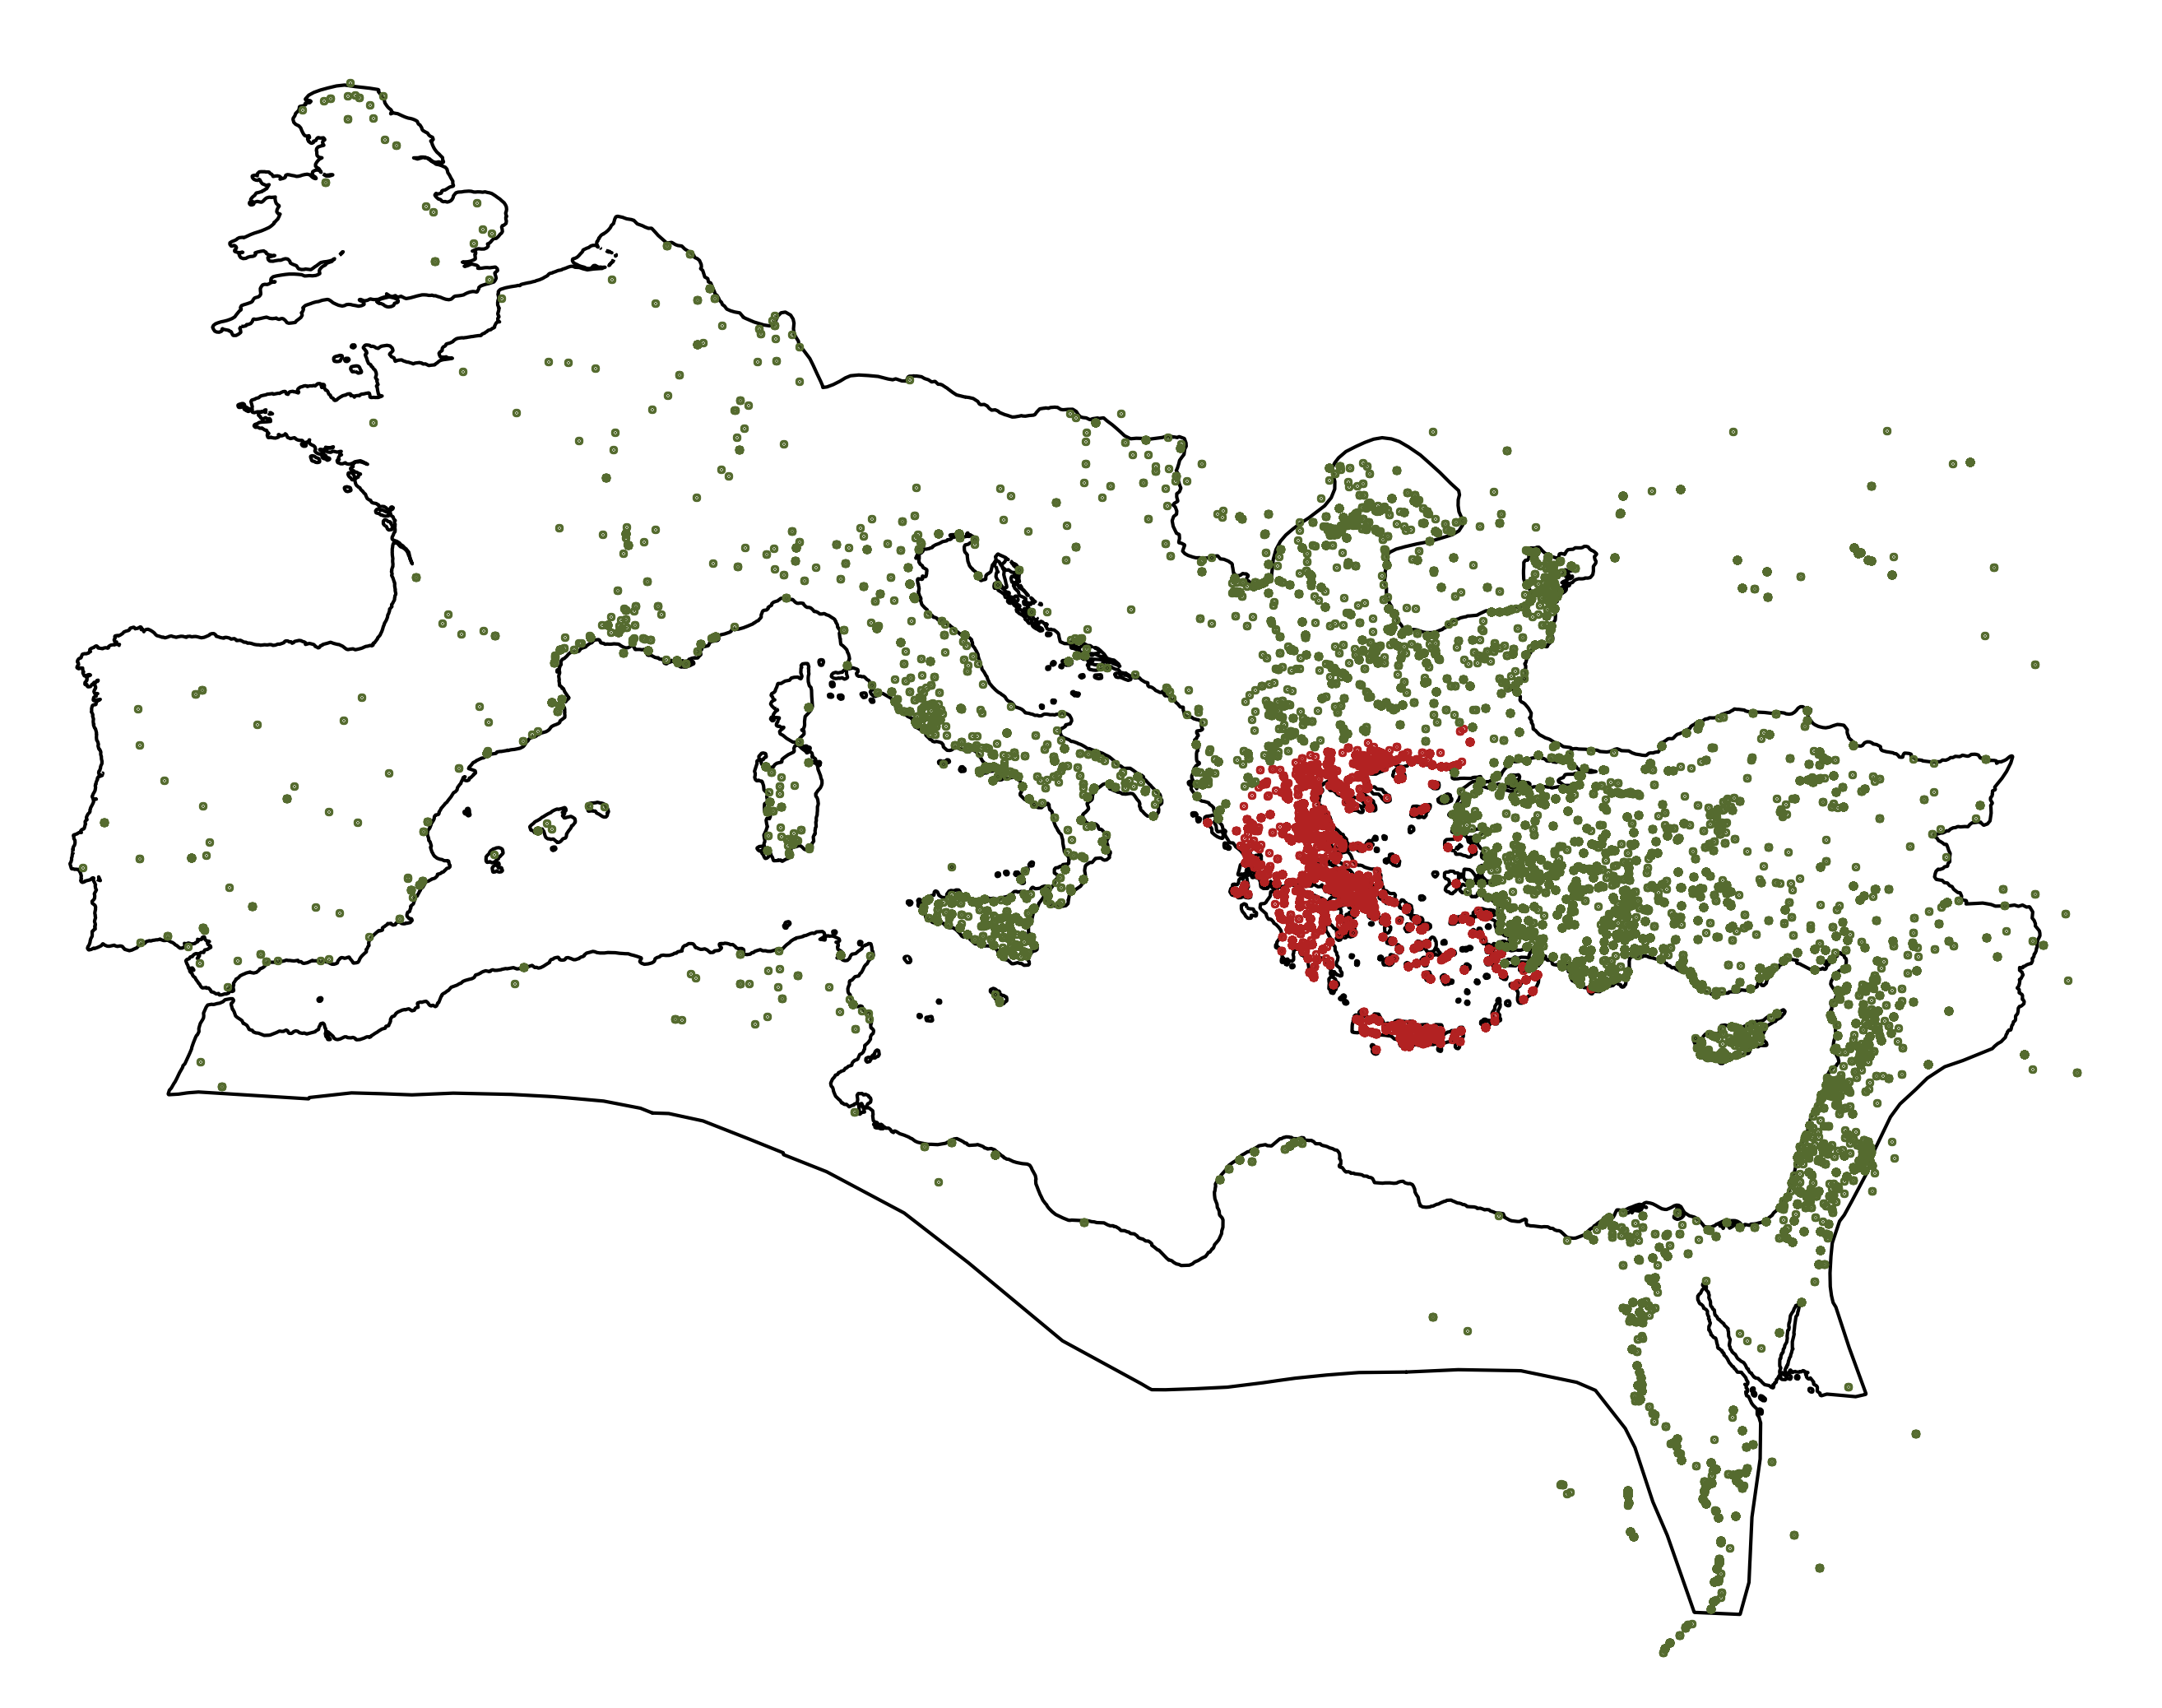

In [125]:
fig, ax = plt.subplots(figsize=(4.45, 3.5), tight_layout=True)
ax.axis("off")
#gplt.kdeplot(GIST[(~GIST["greece?"]) & (GIST["geometry"].notnull())], cmap='Greens', ax=ax, fill=True)
#gplt.kdeplot(GIST[GIST["greece?"]], cmap='Reds', ax=ax, fill=True)

pleiades_regions_merged_buffer_gs.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

GIST[GIST["greece?"]].plot(marker=",", markersize=0.02, ax=ax, color="firebrick") #, alpha=0.7)
GIST[~GIST["greece?"]].plot(marker=",", markersize=0.02, ax=ax, color="darkolivegreen") #, alpha=0.7)

ax.set_xlim(-10,43)
ax.set_ylim(22,56)

In [130]:
GIST.head(5)

,PHI_ID,reference,metadata,lines,text_raw,text_iphi,clean_text_conservative,clean_text_interpretive_word,lemmata,raw_date,not_before,not_after,date_type,region_main_id,region_sub_id,TM_ID,EDH_ID,EDCS_ID,EDR_ID,LUPA_ID,ISic_ID,IG_ID,atticinscriptions_ID,Attalus_ID,TMgeo_ID,x_long,y_lat,TMgeo_name,geometry,greece?
0,1,IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,12.0,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,εδοχσεν τοι δεμοι τ[ος ε σ]αλαμ[ινι κλεροχ]ος ...,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,"{'data': ['ἔδοχσεν', 'δέμοι', 'Σαλαμίς', 'κλερ...",c. 510-500 a.,-511.0,-499.0,"{'data': ['range', 'phase', 'ca']}",1701.0,1700.0,{'data': ['786251']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 1']},{'data': ['1672']},{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True
1,2,IG I³\n2,Att. — non-stoich. — c. 500 a.,14.0,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,[--------]ν βολ ---------- [------] α εκον ---...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"{'data': ['βολ', 'ἑκών', 'σίον', 'γνοσθει', 'ἄ...",c. 500 a.,-505.0,-495.0,"{'data': ['exact', 'phase', 'ca']}",1701.0,1700.0,{'data': ['786252']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 2']},{'data': ['1707']},{'data': []},{'data': ['373']},NaN,NaN,None,None,False
2,3,IG I³\n3,Att. — stoich. 21 — 490-480 a.,13.0,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,[-]αρ[----]ι ερακλειο[-----] [-]αρο [-] τιθενα...,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,"{'data': ['ἑρακλειο', 'ἀρόω', 'τίθημι', 'ἀθλοθ...",490-480 a.,-490.0,-480.0,{'data': ['range']},1701.0,1700.0,{'data': ['786253']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 3']},{'data': ['ii-1b']},{'data': []},{'data': ['373']},NaN,NaN,None,None,False
3,4,IG I³\n4,Att. — stoich. 38 — 485/4 a.,56.0,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,[--------------------------------------] [----...,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,"{'data': ['τὶς', 'φρορὰν', 'πεντέκοντα', 'δραχ...",485/4 a.,-485.0,-484.0,{'data': ['range']},1701.0,1700.0,{'data': ['786254']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},"{'data': ['IG I³ 4(A)', 'IG I³ 4(B)']}",{'data': ['1692']},{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True
4,5,IG I³\n5,Att. — c. 500 a.,6.0,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,[εδοχσε]ν [ τει βολει] και [τ]οι δεμοι οτε παρ...,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,"{'data': ['ἔδοχσεν', 'τει', 'βολει', 'δέμοι', ...",c. 500 a.,-505.0,-495.0,"{'data': ['exact', 'phase', 'ca']}",1701.0,1700.0,{'data': ['786255']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 5']},{'data': ['1284']},{'data': []},{'data': ['10345']},23.541498,38.044135,Eleusis,POINT (23.54150 38.04414),True


In [138]:
GIST = GIST[GIST["geotemporal?"]]

In [139]:
len(GIST[GIST["random_dates"].apply(lambda x: x[0]<-146)])

42915

In [174]:
import matplotlib.patches as mpatches

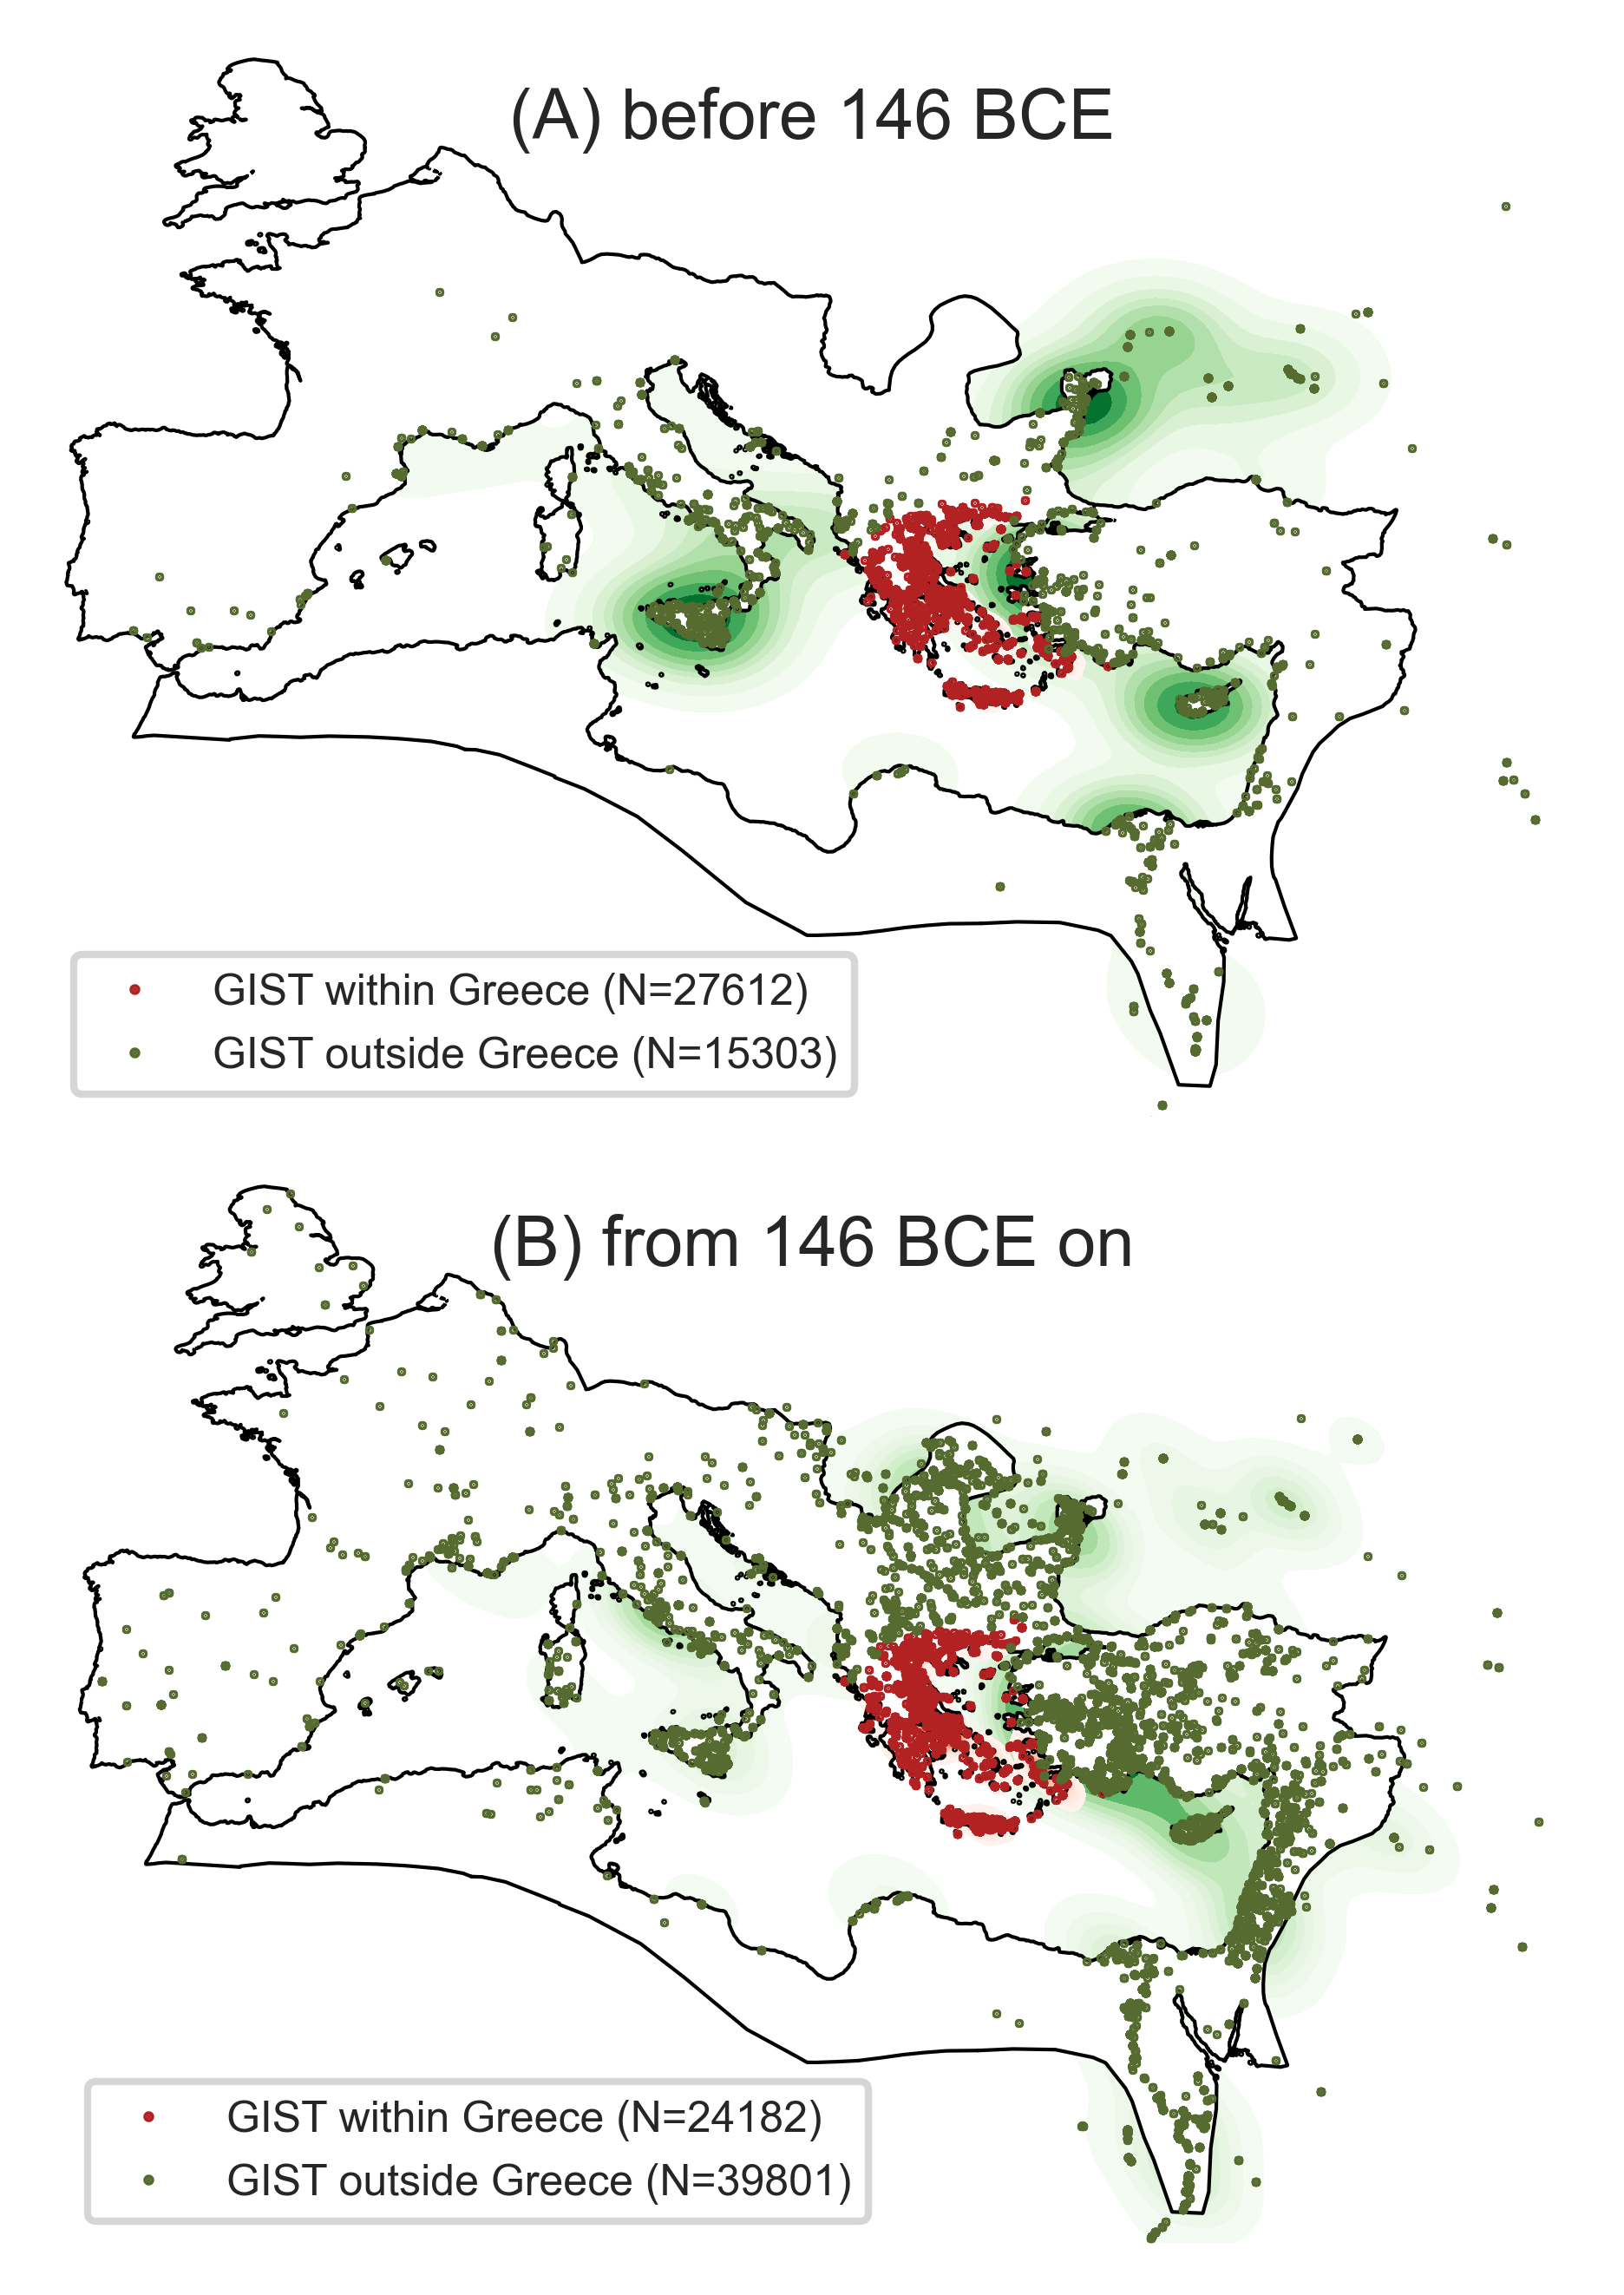

In [190]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(4.45, 4.45), tight_layout=True)

titles=["(A) before 146 BCE", "(B) from 146 BCE on"]

for date_mask, ax, title in zip([GIST["random_dates"].apply(lambda x: x[0]<-146),
                  GIST["random_dates"].apply(lambda x: x[0]>=-146)], [ax1, ax2],
                                titles):

    gplt.kdeplot(GIST[(date_mask) & (~GIST["greece?"])], cmap='Greens', ax=ax, fill=True)
    gplt.kdeplot(GIST[(date_mask) & (GIST["greece?"])], cmap='Reds', ax=ax, fill=True)
    pleiades_regions_merged_buffer_gs.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
    GIST[(date_mask) & (GIST["greece?"])].plot(marker=",", markersize=0.02, ax=ax, color="firebrick") #, alpha=0.7)
    GIST[(date_mask) & (~GIST["greece?"])].plot(marker=",", markersize=0.02, ax=ax, color="darkolivegreen") #, alpha=0.7)
    ax.set_title(title, pad=-12)

    ax.axis("off")
    ax.set_xlim(-10,47)
    ax.set_ylim(22,55.5)

    legend_labels = [
        "GIST within Greece (N={})".format(str(sum((date_mask) & (GIST["greece?"])))),
        "GIST outside Greece (N={})".format(str(sum((date_mask) & (~GIST["greece?"]))))]
    colors=["firebrick", "darkolivegreen"] #, "darkgrey"]
    markers = [plt.Line2D([], [], markersize=0.5, color=color, marker="o", linewidth=0)  for color in colors]
    #markers = [mpatches.Circle((0.05, 0.05), radius=0.02, facecolor=color, edgecolor=None) for color in colors]
    ax.legend(markers, legend_labels, numpoints=1, fontsize=6, bbox_to_anchor=(0.0, 0), loc='lower left')

In [191]:
save_figure(fig, "map_GIST_146BCE")

In [197]:
GIST_gt = GIST[GIST["geotemporal?"]]
polis = polis[(polis["geometry"].notnull()) & (~polis["geometry"].is_empty)]

/Users/kasev/Projects/EpiMR/epimr_venv/lib/python3.9/site-packages/geopandas/geoseries.py:749: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [199]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)

def ckdnearest(inscriptions, polis):

    polis = polis[['name', 'geometry']]
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    polis_geometries = np.array(list(polis.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(polis_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_polis_df = polis.iloc[idx].rename(columns={"geometry": "polis_geo"}).reset_index(drop=True)
    nearest_polis_df["polis_geo"] = [[geom.x, geom.y] for geom in nearest_polis_df["polis_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_polis_df,
            pd.Series(dist, name="polis_dist")
        ],
        axis=1)
    merge_gdf["polis_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row["polis_geo"]), axis=1)
    return merge_gdf

In [200]:
%%time
GIST = ckdnearest(GIST, polis)

CPU times: user 6.47 s, sys: 307 ms, total: 6.78 s
Wall time: 7.08 s


In [201]:
GIST[:230]

,PHI_ID,reference,metadata,lines,text_raw,text_iphi,clean_text_conservative,clean_text_interpretive_word,lemmata,raw_date,not_before,not_after,date_type,region_main_id,region_sub_id,TM_ID,EDH_ID,EDCS_ID,EDR_ID,LUPA_ID,ISic_ID,IG_ID,atticinscriptions_ID,Attalus_ID,TMgeo_ID,x_long,y_lat,TMgeo_name,geometry,greece?,random_dates,geotemporal?,name,polis_geo,polis_dist
0,1,IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,12.0,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,εδοχσεν τοι δεμοι τ[ος ε σ]αλαμ[ινι κλεροχ]ος ...,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,"{'data': ['ἔδοχσεν', 'δέμοι', 'Σαλαμίς', 'κλερ...",c. 510-500 a.,-511.0,-499.0,"{'data': ['range', 'phase', 'ca']}",1701.0,1700.0,{'data': ['786251']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 1']},{'data': ['1672']},{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,"[-504, -508, -502, -504, -509, -501, -504, -51...",True,361-Athenai,"[23.7278, 37.9778]",653.43
1,4,IG I³\n4,Att. — stoich. 38 — 485/4 a.,56.0,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,[--------------------------------------] [----...,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,"{'data': ['τὶς', 'φρορὰν', 'πεντέκοντα', 'δραχ...",485/4 a.,-485.0,-484.0,{'data': ['range']},1701.0,1700.0,{'data': ['786254']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},"{'data': ['IG I³ 4(A)', 'IG I³ 4(B)']}",{'data': ['1692']},{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,"[-485, -485, -484, -485, -484, -484, -484, -48...",True,361-Athenai,"[23.7278, 37.9778]",653.43
2,5,IG I³\n5,Att. — c. 500 a.,6.0,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,[εδοχσε]ν [ τει βολει] και [τ]οι δεμοι οτε παρ...,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,"{'data': ['ἔδοχσεν', 'τει', 'βολει', 'δέμοι', ...",c. 500 a.,-505.0,-495.0,"{'data': ['exact', 'phase', 'ca']}",1701.0,1700.0,{'data': ['786255']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 5']},{'data': ['1284']},{'data': []},{'data': ['10345']},23.541498,38.044135,Eleusis,POINT (23.54150 38.04414),True,"[-502, -503, -495, -503, -500, -501, -499, -50...",True,362-Eleusis,"[23.5423, 38.0394]",530.31
3,6,IG I³\n6,Att. — stoich. 23/11 — ante 460 a.,160.0,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,------------- [---------------] δραχμεισ[ι ---...,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,"{'data': ['δραχμεισι', 'τες', 'μένος', 'δεμο',...",ante 460 a.,NaN,-461.0,{'data': ['ante']},1701.0,1700.0,{'data': ['786256']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 6']},{'data': ['6']},{'data': []},{'data': ['10345']},23.541498,38.044135,Eleusis,POINT (23.54150 38.04414),True,"[-461, -461, -461, -461, -461, -461, -461, -46...",True,362-Eleusis,"[23.5423, 38.0394]",530.31
4,11,IG I³\n11,Att. — stoich. 48 — ante med. s. V a.,22.0,[χσυμμαχία καὶ ℎόρ]κ̣ο̣[ς] Ἀ̣[θ]ε̣ν̣α̣[ίον κα]...,[χσυμμαχια και ορ]κο[ς] α[θ]ενα[ιον κα]ι εγεστ...,κο Ἀεναὶ Ἐγεσταί ο͂ι ἐπρυτάνευε οΙ ον ἐ͂ρχε Ἀ...,χσυμμαχία καὶ ℎόρκος Ἀθεναίον καὶ Ἐγεσταίον ἔδ...,"{'data': ['χσυμμαχία', 'ὅρκος', 'ἀθεναίον', 'ἐ...",ante med. s. V a.,NaN,-456.0,"{'data': ['range', 'cent', 'phase', 'middle', ...",1701.0,1700.0,{'data': ['786261']},{'data': []},{'data': []},{'data': []},{'data': []},{'data': []},{'data': ['IG I³ 11']},{'data': ['5770']},{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,"[-456, -456, -456, -456, -456, -456, -456, -45...",True,361-Athenai,"[23.7278, 37.9778]",653.43
5,14,IG I³\n14,Att. — stoich. 23 — 453/2?,46.0,[ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι· — — — ἐπρ...,[εδοχσεν τει βολει και τοι δεμοι --- επρυτανευ...,ἐπεστάτε ΛΙος

In [202]:
GIST["polis?"] = GIST["polis_dist"] < 5000

In [203]:
def get_duration(start, stop):
    try:
        duration = abs(int(start) - int(stop)) + 1
        if 0 in range(int(start),  int(stop)):
            duration = duration - 1
    except:
        duration = np.nan
    return duration

GIST["duration"] = GIST.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

(-5.0, 305.0)

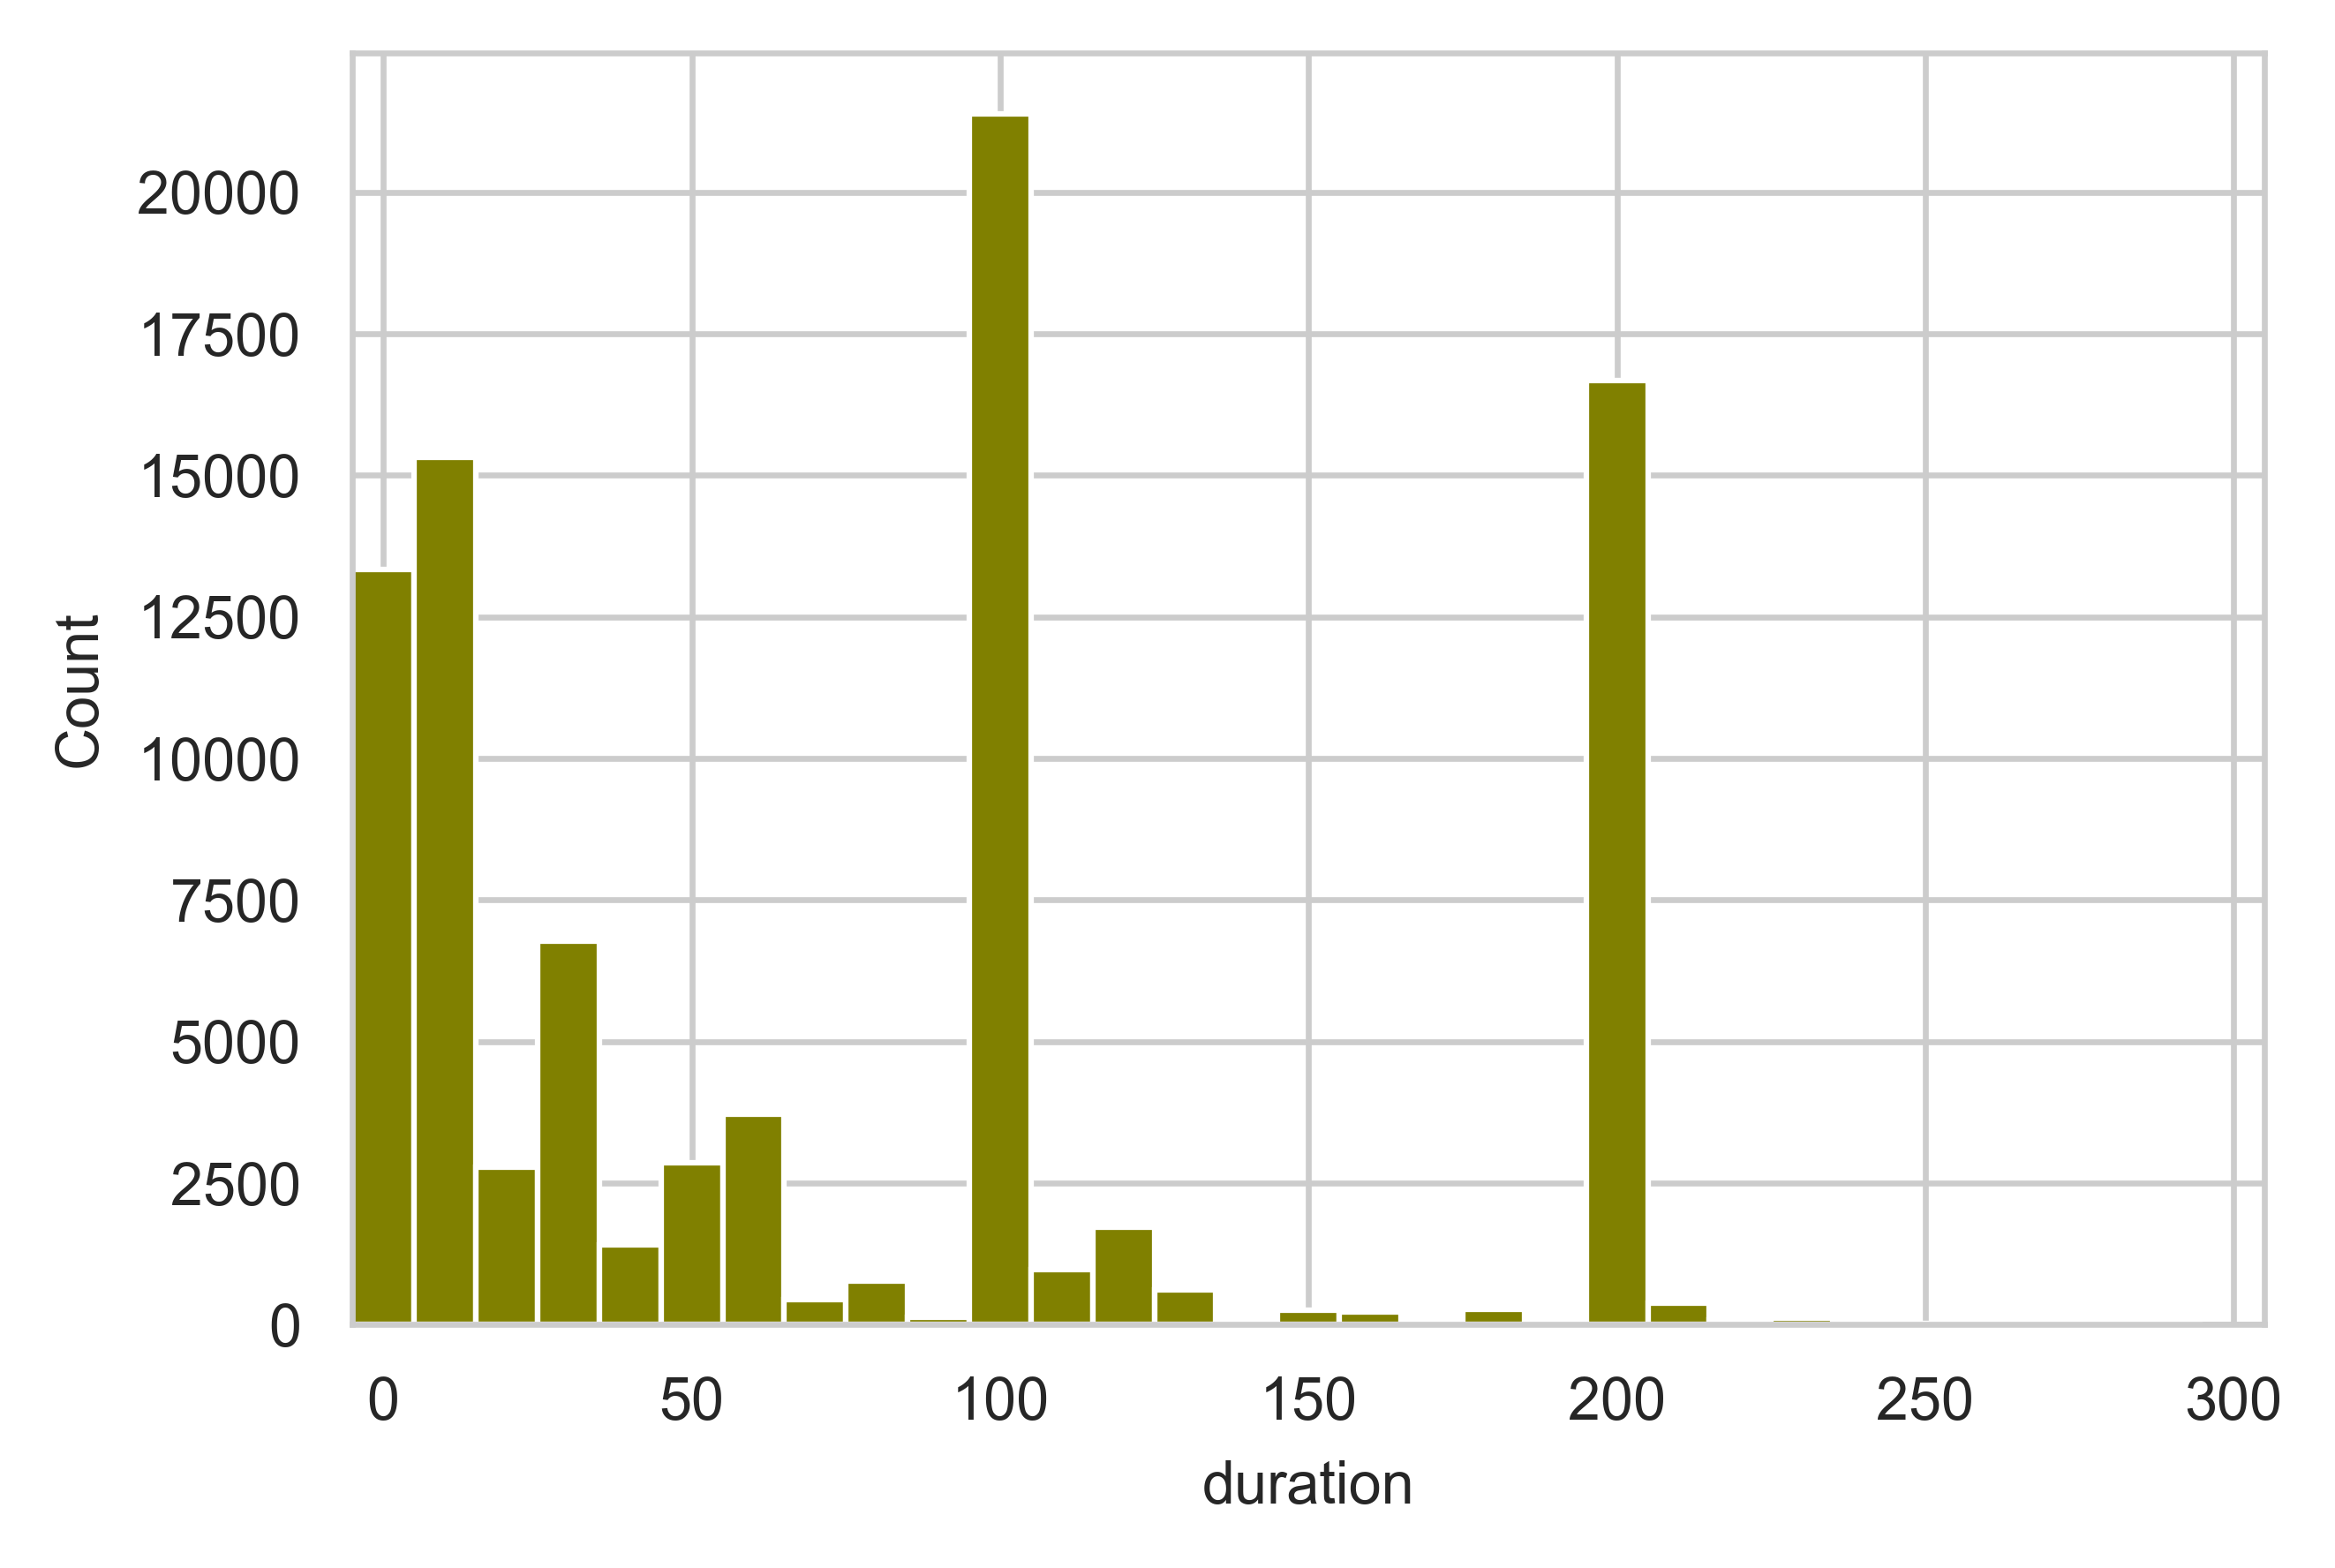

In [204]:
fig, ax = plt.subplots(tight_layout=True)
sns.histplot(GIST["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="olive", ax=ax)
ax.set_xlim(-5, 305)

In [205]:
save_figure(fig, "GIST_duration")

In [206]:
LIST = gpd.read_parquet("../../LIRE_ETL/data/large_data/LIST_v0.1.parquet")

In [207]:
LIST["random_dates"] = LIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

In [208]:
len(LIST)

157800

In [209]:
sum((LIST["not_before"].notnull()) | (LIST["not_after"].notnull()))

157800

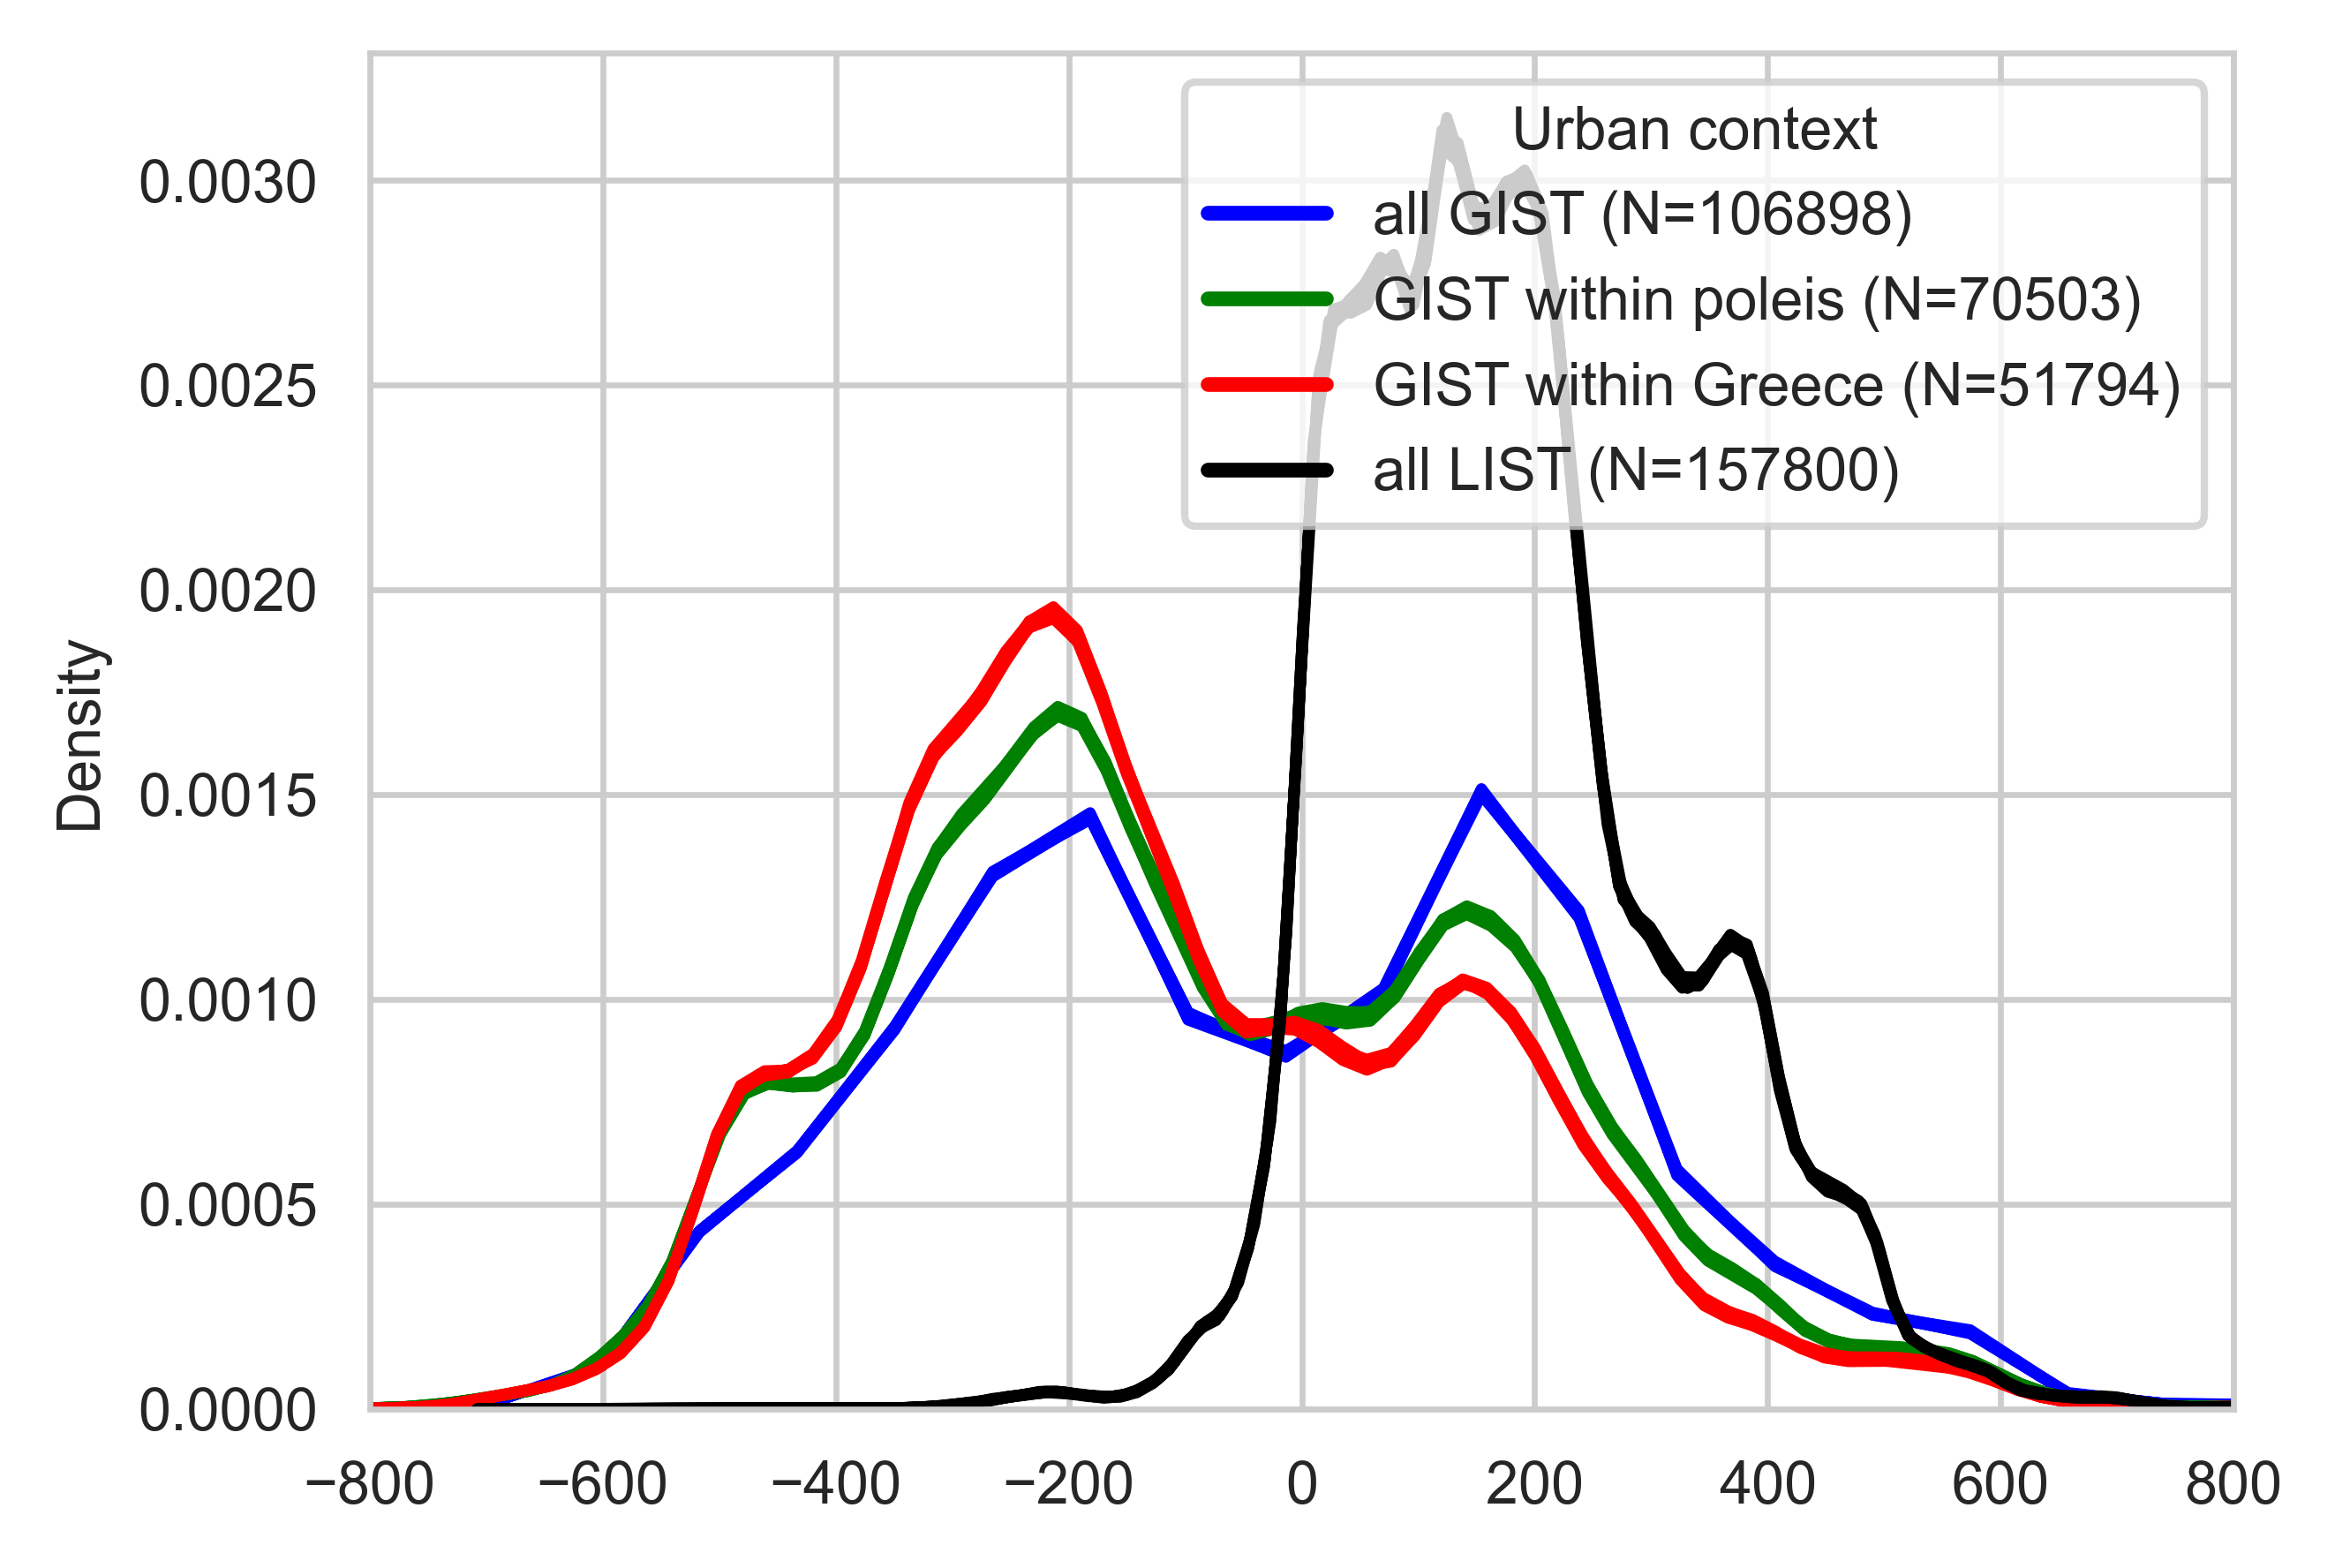

In [210]:
fig, ax = plt.subplots(tight_layout=True)
tempun.kdeplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", random_size=10)
tempun.kdeplot_from_randoms(LIST["random_dates"], ax=ax, color="black", random_size=10)
ax.set_xlim(-800,800)

legend_labels = ["all GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red", "black"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper right')

In [74]:
GIST = GIST[GIST["random_dates"].notnull()]

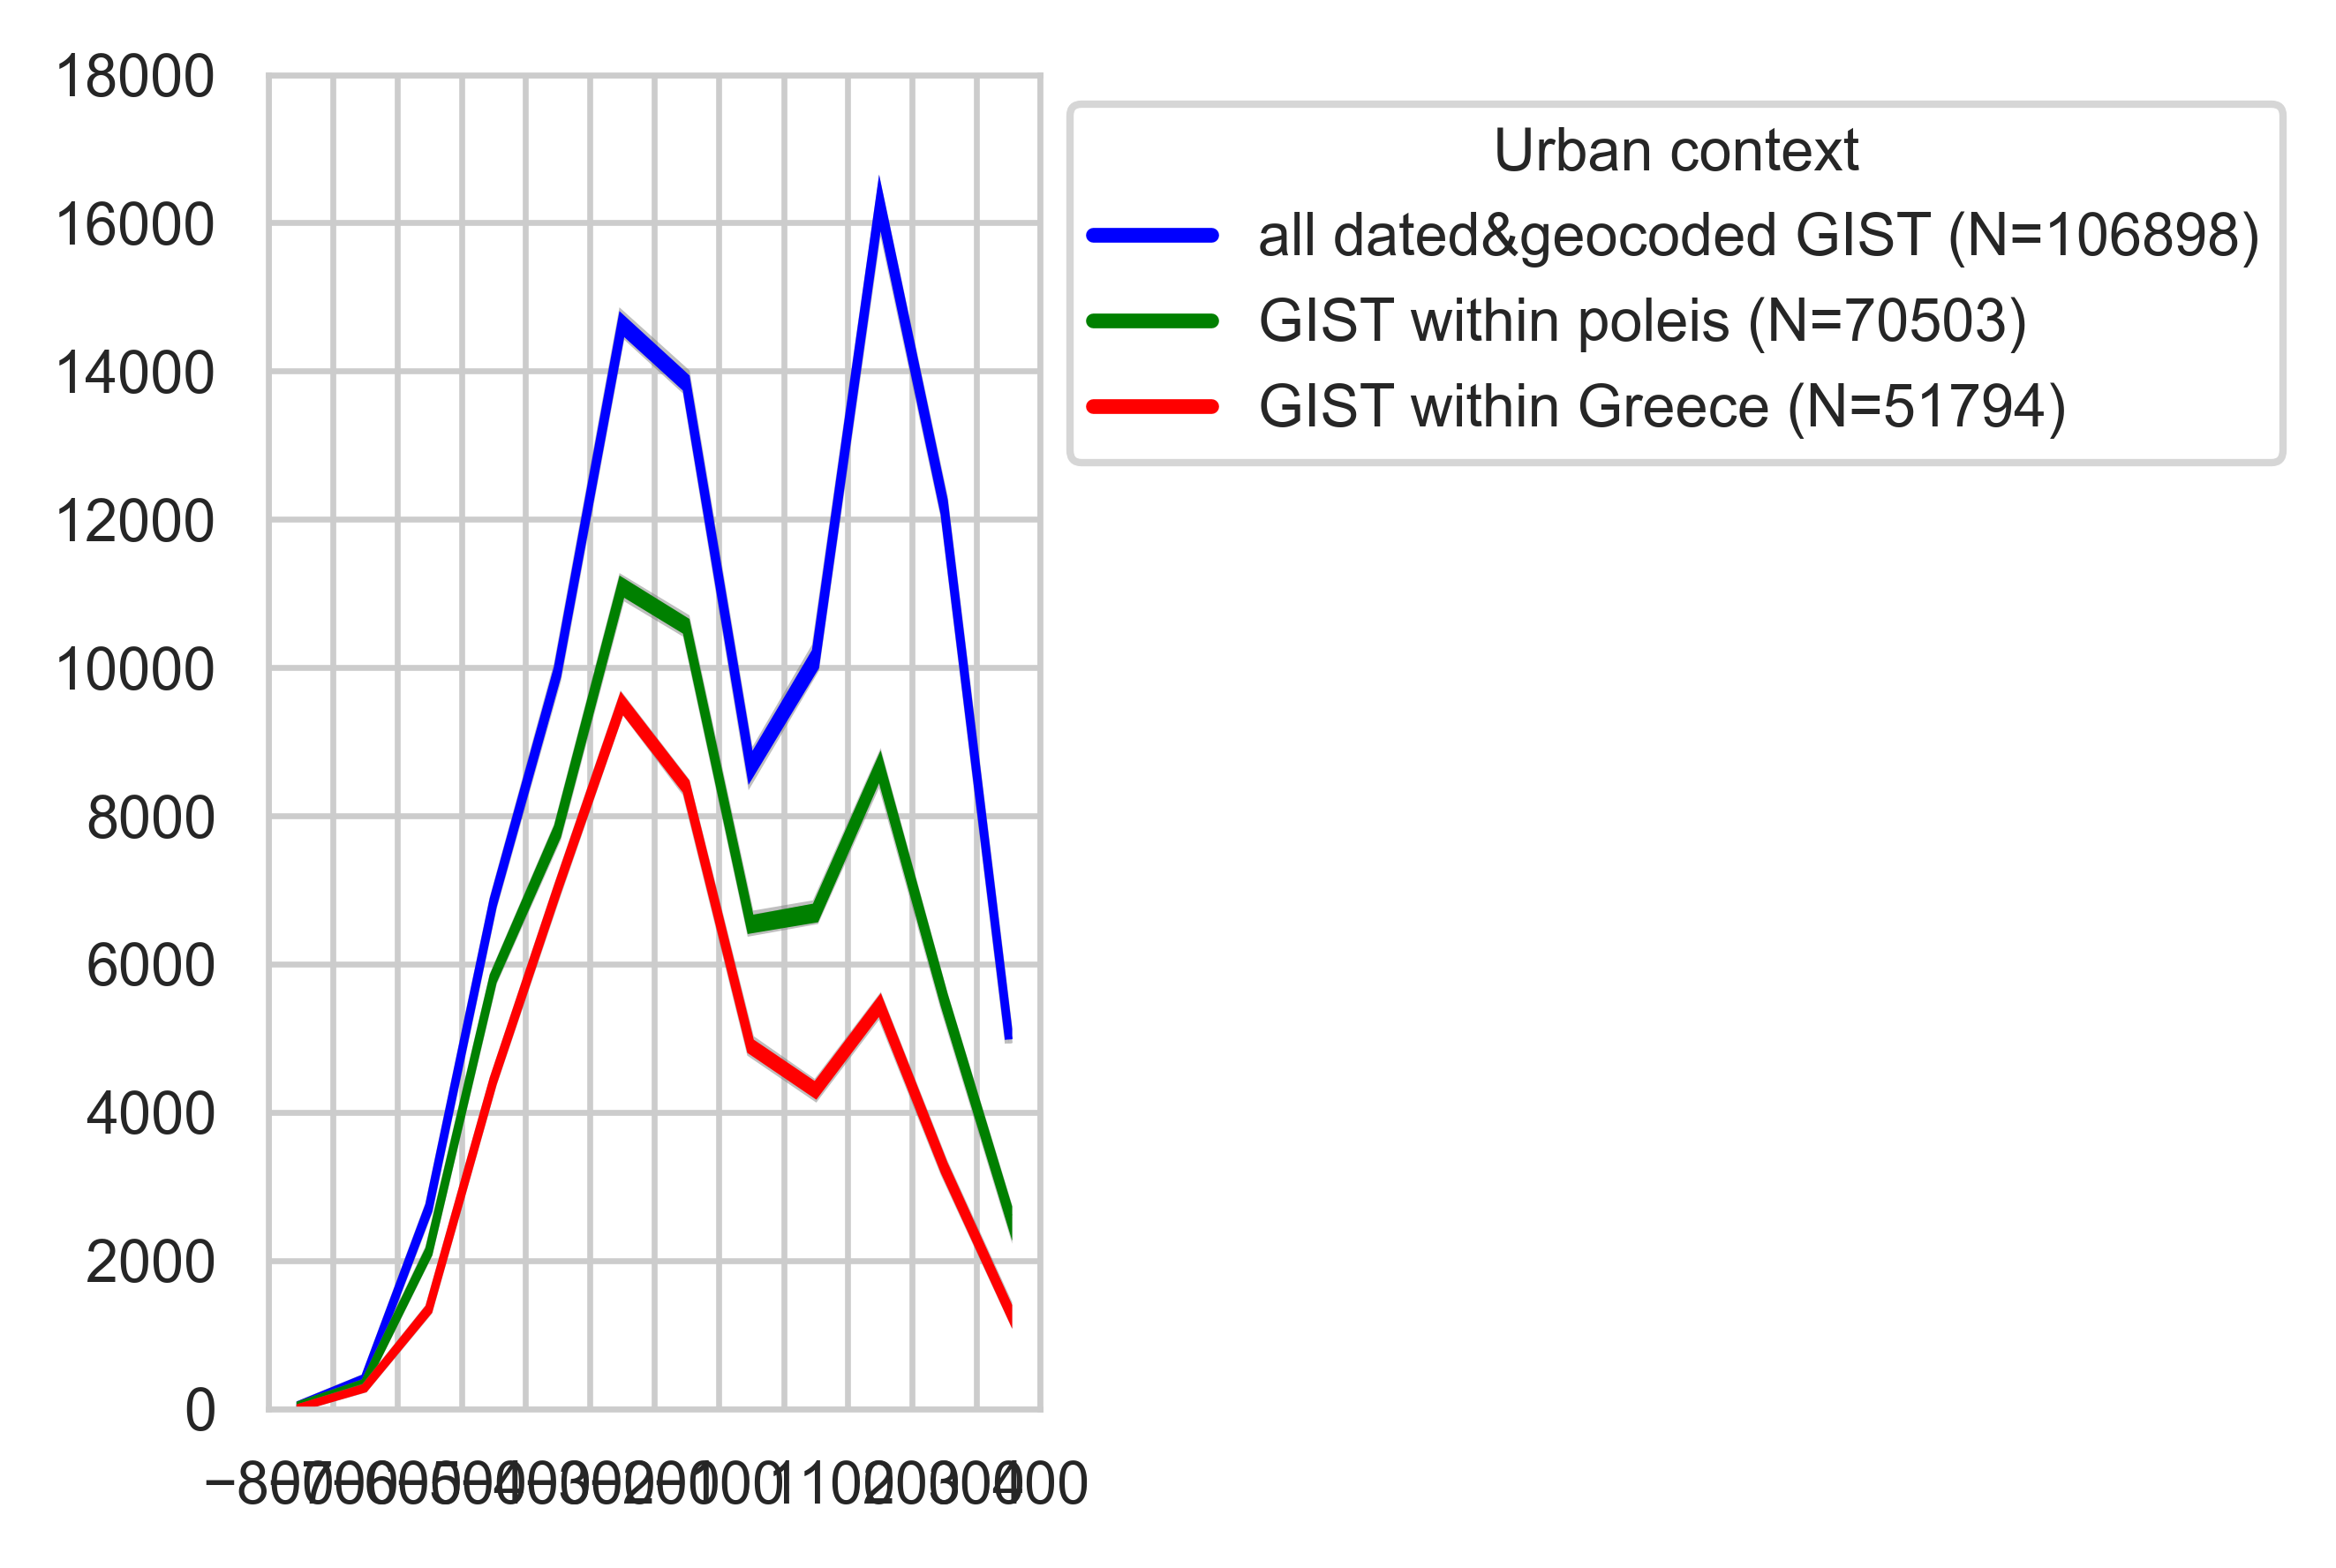

In [212]:
fig, ax = plt.subplots(tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,18000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = ["all dated&geocoded GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"])))]
                 #"all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper left')

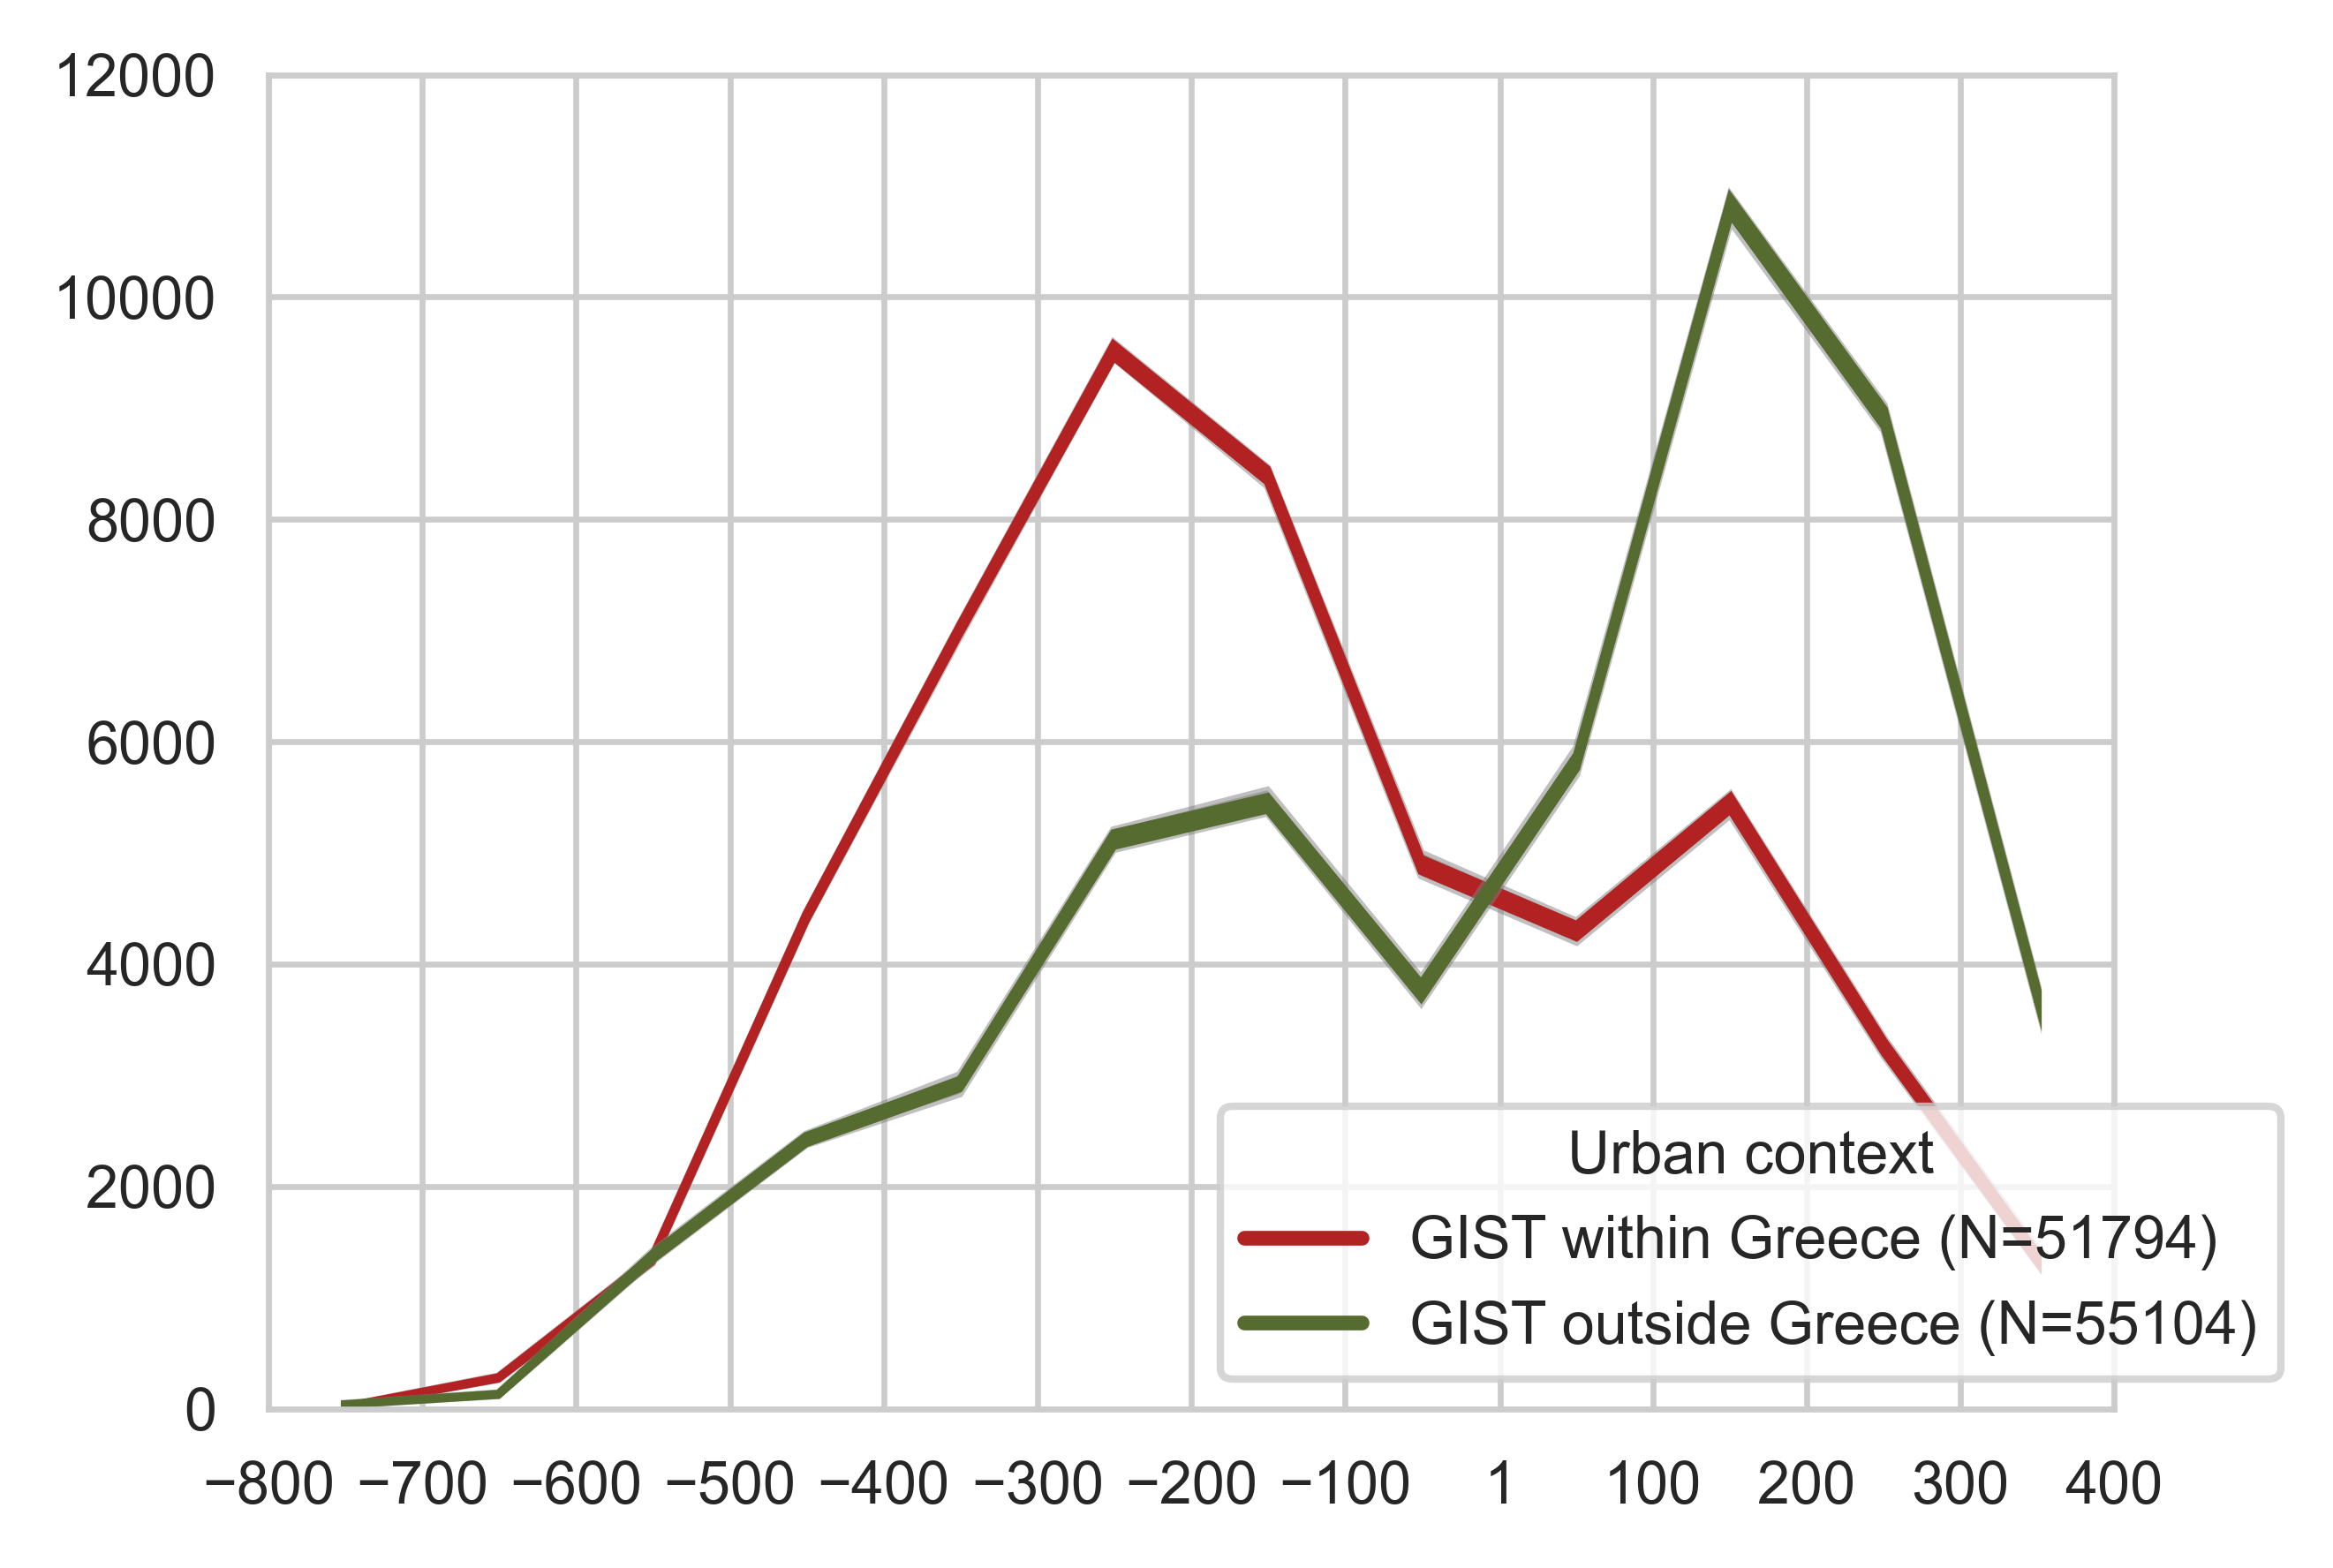

In [213]:
fig, ax = plt.subplots(tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="firebrick", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[~GIST["greece?"]]["random_dates"], ax=ax, color="darkolivegreen", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,12000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = [
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "GIST outside Greece (N={})".format(str(sum(~GIST["greece?"])))]
#"all LIST (N={})".format(str(len(LIST)))]
colors=["firebrick", "darkolivegreen"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(0.5, 0), loc='lower left')

In [214]:
data = []
for cent in range(-8, 4):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
        cent_label = "{} BCE".format(str(abs(cent)))
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
        cent_label = "{} CE".format(str(cent + 1))
    subset = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]
    words_N = sum(subset["clean_text_interpretive_word"].apply(lambda x: len(x.split())))
    data.append({"cent_raw": cent,  "cent_label" : cent_label, "inscr_N" : len(subset), "words_N" : words_N})

In [215]:
cent_overview = pd.DataFrame(data)
cent_overview

,cent_raw,cent_label,inscr_N,words_N
0,-8,8 BCE,57,259
1,-7,7 BCE,405,2121
2,-6,6 BCE,2579,15159
3,-5,5 BCE,6690,68950
4,-4,4 BCE,9629,278518
5,-3,3 BCE,14184,488942
6,-2,2 BCE,13554,639027
7,-1,1 BCE,8397,200482
8,0,1 CE,9893,183330
9,1,2 CE,15928,323023


In [216]:
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    print(x, y, label)

-8 57 57
-7 405 405
-6 2579 2579
-5 6690 6690
-4 9629 9629
-3 14184 14184
-2 13554 13554
-1 8397 8397
0 9893 9893
1 15928 15928
2 11943 11943
3 4969 4969


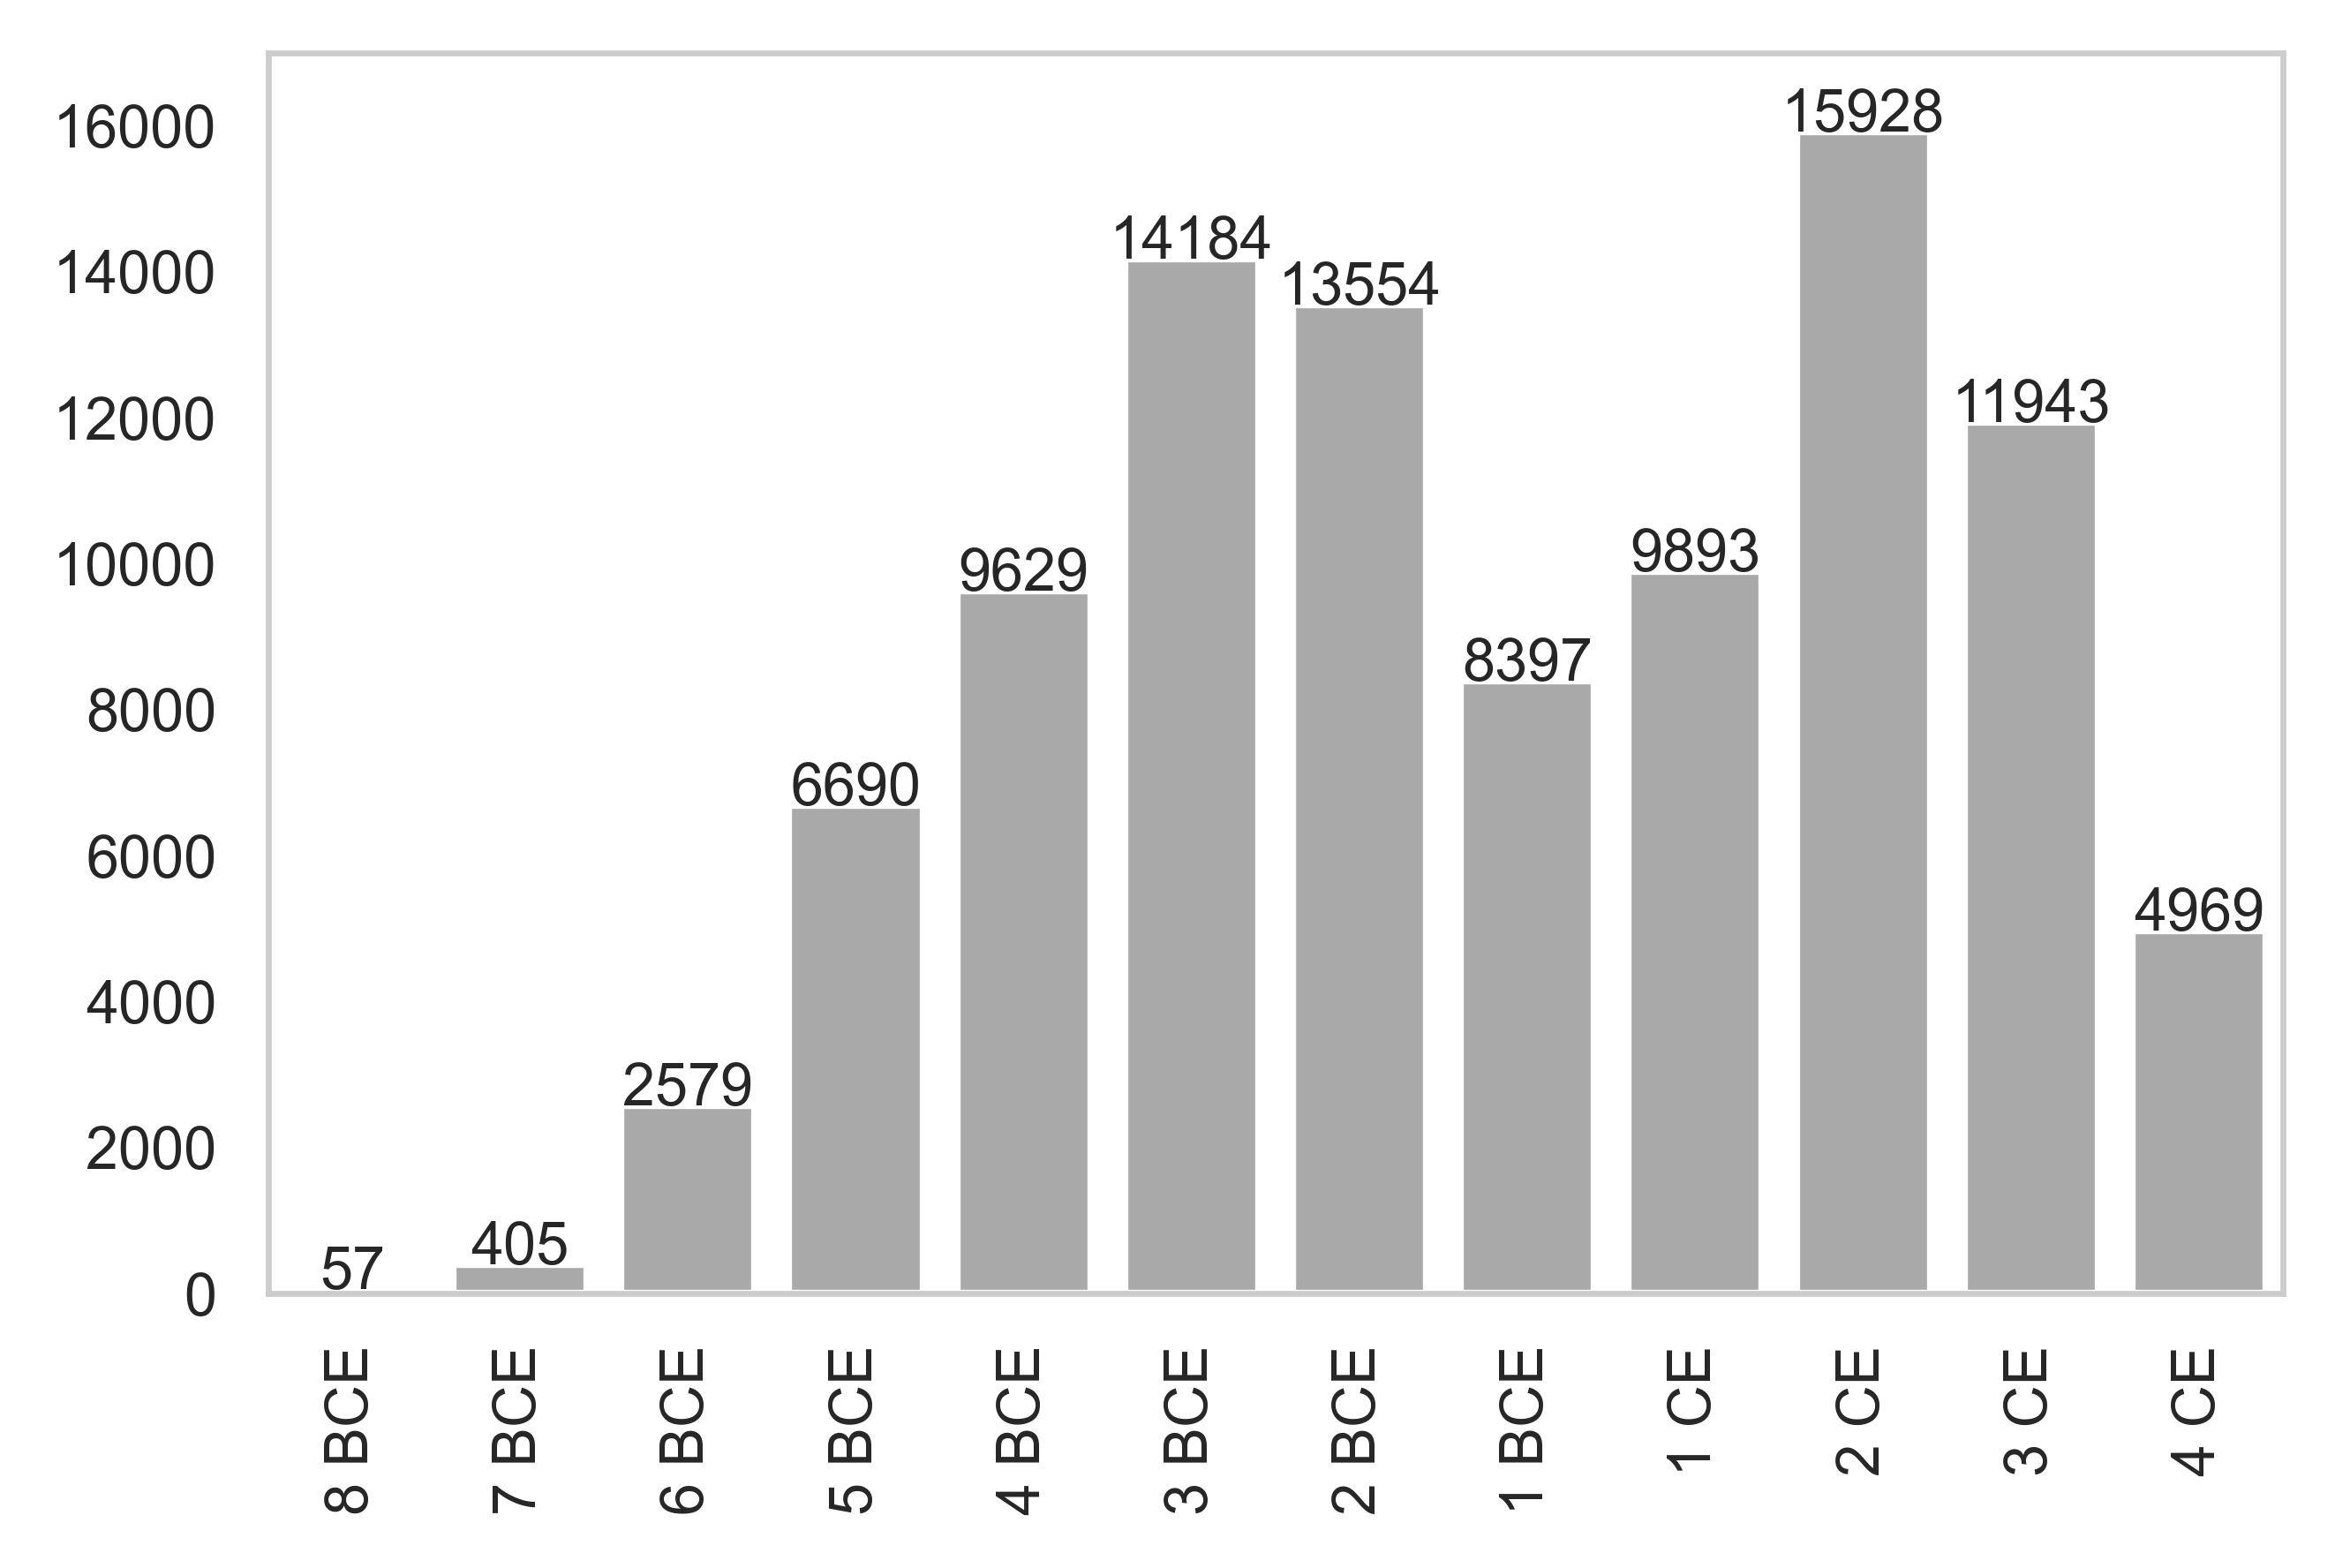

In [218]:
fig, ax = plt.subplots(tight_layout=True)
ax.bar(cent_overview["cent_raw"], cent_overview["inscr_N"], color="darkgrey")
ax.set_xlim(-8.5,3.5)
ax.set_ylim(0,17000)
ax.set_xticks(cent_overview["cent_raw"])
ax.set_xticklabels(cent_overview["cent_label"], rotation=90)
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    ax.text(x=x, y=y, s=label, horizontalalignment="center")
ax.grid(False)

In [219]:
save_figure(fig, "GIST_temporal_bars")

In [220]:
#!mkdir ../data/large_files
GIST.to_parquet("../data/large_files/GIST_geocontexts.parquet")